# **0. Importación de <ins>librerías</ins> y <ins>carga de archivos</ins>**

In [1]:
## IMPORTACIÓN DE LIBRERÍAS

import pandas as pd # Pandas
import matplotlib.pyplot as plt # Matplorlib
import matplotlib.colors as mcolors # Matplorlib
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta # Dates
import seaborn as sns #Seaborn
import numpy as np #Numpy
from matplotlib.colors import LinearSegmentedColormap #Paleta de colores
import pycaret
from pycaret.regression import *
from prophet import Prophet

# Desactivamos Warnings
#import warnings
#warnings.filterwarnings('ignore')



In [2]:
# Cargar los archivos CSV
df_Promos = pd.read_csv('/mnt/c6c29b92-c396-4913-b7c7-b2456280d17a/Software y Programación/Ciencia de Datos/Datathon/ProdEnPromo-UM.csv')
df_Productos = pd.read_csv('/mnt/c6c29b92-c396-4913-b7c7-b2456280d17a/Software y Programación/Ciencia de Datos/Datathon/Producto-UM.csv')
df_Ventas = pd.read_csv('/mnt/c6c29b92-c396-4913-b7c7-b2456280d17a/Software y Programación/Ciencia de Datos/Datathon/VentasPR.csv')

# Ahora df1, df2, y df3 son DataFrames de pandas que contienen los datos de cada archivo CSV respectivamente.

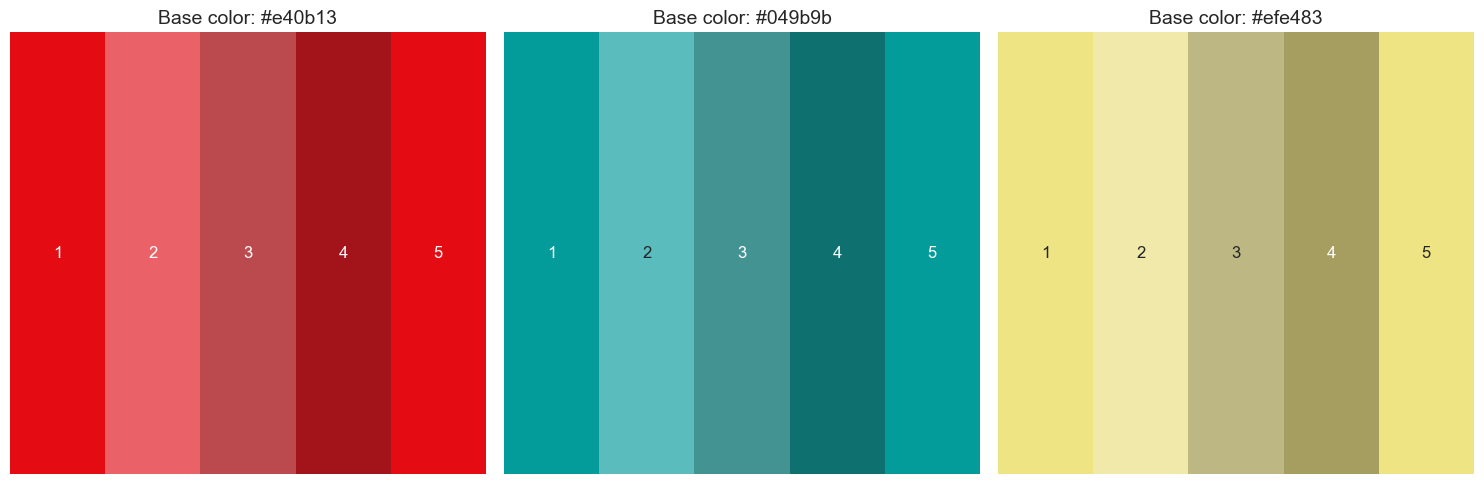

In [3]:
## DEFINICIÓN DE PALETA DE COLORES


# Colores base
colores_base = ['#e40b13', '#049b9b', '#efe483']

# Función para generar colores más claros y más oscuros
def generar_paleta(color_hex, num_colores=5):
    # Convertir el color HEX a RGB
    color_rgb = mcolors.hex2color(color_hex)
    # Generar colores más claros y más oscuros
    paleta = sns.light_palette(color_rgb, n_colors=(num_colores // 2) + 1, reverse=True)[:-1] + \
             sns.dark_palette(color_rgb, n_colors=(num_colores // 2) + 1)[1:]
    return paleta

# Generar las paletas
paletas = [generar_paleta(color) for color in colores_base]

# Crear una función para graficar con degradado
def plot_bar_with_gradient(ax, data, labels, palette, title, ylabel, value_format):
    norm = plt.Normalize(data.min(), data.max())
    colors = [palette[int(norm(value) * (len(palette) - 1))] for value in data]
    bars = ax.bar(labels, data, color=colors)
    for bar, value in zip(bars, data):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), value_format.format(value).replace(',', '.'),
                ha='center', va='bottom', fontsize=10)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Mes-Año')
    ax.set_xticklabels(labels, rotation=90)

# Visualizar las paletas
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for ax, paleta, color_base in zip(axs, paletas, colores_base):
    sns.heatmap(np.arange(1, 6).reshape(1, 5), ax=ax, cmap=LinearSegmentedColormap.from_list("", paleta),
                cbar=False, annot=True, xticklabels=False, yticklabels=False)
    ax.set_title(f'Base color: {color_base}', fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

---

# **1. Exploración inicial de las bases**

In [4]:
## BASE PROMO

df_Promos

# PRDCODEXT: Código que identifica al producto
# PROMEFFECDES: Fecha desde cunado entró en promoción
# PROMDEFFECHAS: Fecha hasta cuando duró la promoción

# Renombramos columnas
df_Promos.rename(columns={
    'PRDCODEXT': 'ID_producto',
    'PROMDEFFECDES': 'Inicio_promo',
    'PROMDEFFECHAS': 'Fin_promo'
}, inplace=True)

# Convertimos las columnas de fechas en formato "datetime64"
df_Promos['Inicio_promo'] = pd.to_datetime(df_Promos['Inicio_promo'], format='%d/%m/%Y')
df_Promos['Fin_promo'] = pd.to_datetime(df_Promos['Fin_promo'], format='%d/%m/%Y')

# Convertimos "ID_producto" formato String -> Esta variable corresponde a código, por lo cual no deben ser interpretada como variable numérica
df_Promos['ID_producto'] = df_Promos['ID_producto'].astype(float).astype(int).astype(str)

# Creamos la variable "Duracion_promo"
df_Promos['Duracion_promo'] = (df_Promos['Fin_promo'] - df_Promos['Inicio_promo']).dt.days

# Proyectamos Dataframe
df_Promos.head(10)

,ID_producto,Inicio_promo,Fin_promo,Duracion_promo
0,560226,2023-02-13,2023-02-26,13
1,560227,2023-02-13,2023-02-26,13
2,561875,2023-02-13,2023-02-26,13
3,561895,2023-02-13,2023-02-26,13
4,561899,2023-02-13,2023-02-26,13
5,600936,2021-05-17,2021-05-30,13
6,607016,2021-05-17,2021-05-30,13
7,607064,2021-05-17,2021-05-30,13
8,607065,2021-05-17,2021-05-30,13
9,607066,2021-05-17,2021-05-30,13


In [5]:
## BASE PRODUCTO

df_Productos

# Cod: Código que identifica el producto
# Status Hoy: Situación del producto: 1- Activo, 2- Congelado, 3- Congelado para la compra
# Prov: Código que identifica al proveedor
# Cat: 216: Vinos finos, 217 Espumantes
# Tipo Prov: Tipo de proveedor; 1- Provedor Externo, 3- Logistico

# Renombramos columnas
df_Productos.rename(columns={
    'Cod': 'ID_producto',
    'Status Hoy': 'Status',
    'Prov': 'ID_proveedor',
    'Cat ': 'Categoria',
    'Tipo Prov': 'Clasif_proveedor'
}, inplace=True)

# Convertimos "ID_producto", "Status", "ID_proveedor", "Categoria" y "Clasif_proveedor" a formato String -> Estas variables corresponden a códigos, por lo cual no deben ser interpretadas como variables numéricas
df_Productos['ID_producto'] = df_Productos['ID_producto'].astype(float).astype(int).astype(str)
df_Productos['Status'] = df_Productos['Status'].astype(float).astype(int).astype(str)
df_Productos['ID_proveedor'] = df_Productos['ID_proveedor'].astype(float).astype(int).astype(str)
df_Productos['Categoria'] = df_Productos['Categoria'].astype(float).astype(int).astype(str)
df_Productos['Clasif_proveedor'] = df_Productos['Clasif_proveedor'].astype(float).astype(int).astype(str)

# Proyectamos Dataframe
df_Productos.head(10)

,ID_producto,Status,ID_proveedor,Categoria,Clasif_proveedor
0,561699,5,68952,216,1
1,561634,5,68952,216,1
2,561694,5,68952,216,1
3,561826,5,68952,216,1
4,561891,5,68952,216,1
5,561900,5,68952,216,1
6,604124,5,10067,216,1
7,604710,1,10214,216,1
8,560912,5,10214,216,1
9,601047,5,10214,216,1


In [6]:
## BASE VENTAS

df_Ventas

# LOCCOD: Número de Local
# MOVFEC: Fecha de Venta
# PRDCODEXT: Código de producto vendido
# ACPRCANTVEND: Cantidades vendidas
# ACPRIMPVEN: Facturación

# Renombramos columnas
df_Ventas.rename(columns={
    'LOCCOD': 'ID_tienda',
    'MOVFEC': 'Fecha_venta',
    'PRDCODEXT': 'ID_producto',
    'ACPRCANTVEND': 'Cant_vendidas',
    'ACPRIMPVEN': 'Facturacion'
}, inplace=True)

# Convertimos las columnas de fechas en formato "datetime64"
df_Ventas['Fecha_venta'] = pd.to_datetime(df_Ventas['Fecha_venta'], format='%d/%m/%Y')

# Convertimos "ID_producto", "ID_tienda" a formato String -> Estas variables corresponden a códigos, por lo cual no deben ser interpretadas como variables numéricas
df_Ventas['ID_producto'] = df_Ventas['ID_producto'].astype(float).astype(int).astype(str)
df_Ventas['ID_tienda'] = df_Ventas['ID_tienda'].astype(float).astype(int).astype(str)

# Convertimos las columnas "Facturacion" y "Cant_vendidas" a cadena para poder reemplazar comas por puntos
df_Ventas['Facturacion'] = df_Ventas['Facturacion'].astype(str).str.replace(',', '.').astype(float)
df_Ventas['Cant_vendidas'] = df_Ventas['Cant_vendidas'].astype(str).str.replace(',', '.').astype(int)

# Crear la variable "Precio_unidad"
df_Ventas['Precio_unidad'] = df_Ventas['Facturacion'] / df_Ventas['Cant_vendidas']


# Diccionario para denominar los días de semana en español
dias_semana = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}

# Creamos la variable "Dia_sem" en español
df_Ventas['Dia_sem'] = df_Ventas['Fecha_venta'].dt.day_name().map(dias_semana)

# Proyectamos Dataframe
df_Ventas.head(10)

,ID_tienda,Fecha_venta,ID_producto,Cant_vendidas,Facturacion,Precio_unidad,Dia_sem
0,5201,2021-05-02,600790,7,1393.0,199.0,Domingo
1,5201,2021-05-02,600793,2,390.0,195.0,Domingo
2,5201,2021-05-02,600794,7,2023.0,289.0,Domingo
3,5201,2021-05-02,605089,1,399.0,399.0,Domingo
4,5201,2021-05-02,605097,1,565.0,565.0,Domingo
5,5201,2021-05-02,605548,1,305.0,305.0,Domingo
6,5201,2021-05-02,607019,1,429.0,429.0,Domingo
7,5201,2021-05-02,607064,2,670.0,335.0,Domingo
8,5201,2021-05-02,607065,1,335.0,335.0,Domingo
9,5201,2021-05-02,607188,1,329.0,329.0,Domingo


---

# **2. <ins>Unificación</ins> y <ins>simplificación</ins> de las bases de datos**

In [7]:
# Realizar el merge entre df_Productos y df_Ventas
df_merged = pd.merge(df_Ventas, df_Productos, on='ID_producto', how='left')

# Proyectamos el dataframe resultante
df_merged.head(10)

,ID_tienda,Fecha_venta,ID_producto,Cant_vendidas,Facturacion,Precio_unidad,Dia_sem,Status,ID_proveedor,Categoria,Clasif_proveedor
0,5201,2021-05-02,600790,7,1393.0,199.0,Domingo,1,31064,216,1
1,5201,2021-05-02,600793,2,390.0,195.0,Domingo,1,31064,216,1
2,5201,2021-05-02,600794,7,2023.0,289.0,Domingo,1,31064,216,1
3,5201,2021-05-02,605089,1,399.0,399.0,Domingo,1,22010,216,1
4,5201,2021-05-02,605097,1,565.0,565.0,Domingo,5,10145,216,1
5,5201,2021-05-02,605548,1,305.0,305.0,Domingo,1,31062,216,1
6,5201,2021-05-02,607019,1,429.0,429.0,Domingo,1,10145,216,1
7,5201,2021-05-02,607064,2,670.0,335.0,Domingo,1,10214,216,1
8,5201,2021-05-02,607065,1,335.0,335.0,Domingo,1,10214,216,1
9,5201,2021-05-02,607188,1,329.0,329.0,Domingo,5,10214,216,1


In [8]:
## Corroboramos que no existan duplicados
df_merged.duplicated().sum()

0

In [9]:
## Eliminamos del Dataframe las DEVOLUCIONES DE PRODUCTOS

# Contar las veces que "Cant_vendidas" es inferior a 0
cant_vendidas_menor_0 = df_merged[df_merged['Cant_vendidas'] < 0].shape[0]
print(f"Número de veces que 'Cant_vendidas' es menor a 0: {cant_vendidas_menor_0}")

# Contar las veces que "Cant_vendidas" es igual a 0
cant_vendidas_igual_0 = df_merged[df_merged['Cant_vendidas'] == 0].shape[0]
print(f"Número de veces que 'Cant_vendidas' es igual a 0: {cant_vendidas_igual_0}")

# Contar las veces que "Cant_vendidas" es nulo
cant_vendidas_nulo = df_merged['Cant_vendidas'].isnull().sum()
print(f"Número de veces que 'Cant_vendidas' es nulo: {cant_vendidas_nulo}")

# Eliminar filas donde "Cant_vendidas" es menor o igual a 0 o es nulo
df_merged_cleaned = df_merged[df_merged['Cant_vendidas'] > 0].dropna(subset=['Cant_vendidas'])

Número de veces que 'Cant_vendidas' es menor a 0: 132
Número de veces que 'Cant_vendidas' es igual a 0: 997
Número de veces que 'Cant_vendidas' es nulo: 0


In [10]:
## Detectamos que variables cuentan con valores faltantes

df_merged.isnull().sum()

ID_tienda             0
Fecha_venta           0
ID_producto           0
Cant_vendidas         0
Facturacion           0
Precio_unidad       192
Dia_sem               0
Status              239
ID_proveedor        239
Categoria           239
Clasif_proveedor    239
dtype: int64

In [11]:
## Eliminamos aquellas ventas donde se presenten valores faltantes para alguna de las variables. Esto se realiza en pos de ejecutar correctamente los modelos de machine learning a posteriori

# Contar el número de filas con algún valor faltante antes de eliminar
valores_faltantes = df_merged.isnull().sum().sum()
print(f"Número de valores faltantes en el dataframe: {valores_faltantes}")

# Eliminar filas con cualquier valor faltante
df_merged = df_merged.dropna()

# Contar el número de filas después de eliminar
print(f"Número de filas después de eliminar valores faltantes: {df_merged.shape[0]}")

Número de valores faltantes en el dataframe: 1148
Número de filas después de eliminar valores faltantes: 144857


In [12]:
## VERIFICACIÓN DE SI UN PRODUCTO VENDIDO SE ENCUENTRA EN PROMO

# Creamos una función para verificar si un producto estaba en promoción en una fecha dada
def verificar_promocion(row):
    producto = row['ID_producto']
    fecha_venta = row['Fecha_venta']
    promocion = df_Promos[(df_Promos['ID_producto'] == producto) &
                          (df_Promos['Inicio_promo'] <= fecha_venta) &
                          (df_Promos['Fin_promo'] >= fecha_venta)]
    return 'Si' if not promocion.empty else 'No'

# Aplicamos la función a cada fila del dataframe
df_merged_cleaned['Promocion'] = df_merged_cleaned.apply(verificar_promocion, axis=1)

# Proyectamos el dataframe resultante
df_merged_cleaned.head(10)

,ID_tienda,Fecha_venta,ID_producto,Cant_vendidas,Facturacion,Precio_unidad,Dia_sem,Status,ID_proveedor,Categoria,Clasif_proveedor,Promocion
0,5201,2021-05-02,600790,7,1393.0,199.0,Domingo,1,31064,216,1,No
1,5201,2021-05-02,600793,2,390.0,195.0,Domingo,1,31064,216,1,No
2,5201,2021-05-02,600794,7,2023.0,289.0,Domingo,1,31064,216,1,No
3,5201,2021-05-02,605089,1,399.0,399.0,Domingo,1,22010,216,1,No
4,5201,2021-05-02,605097,1,565.0,565.0,Domingo,5,10145,216,1,No
5,5201,2021-05-02,605548,1,305.0,305.0,Domingo,1,31062,216,1,No
6,5201,2021-05-02,607019,1,429.0,429.0,Domingo,1,10145,216,1,No
7,5201,2021-05-02,607064,2,670.0,335.0,Domingo,1,10214,216,1,No
8,5201,2021-05-02,607065,1,335.0,335.0,Domingo,1,10214,216,1,No
9,5201,2021-05-02,607188,1,329.0,329.0,Domingo,5,10214,216,1,No


---

# **3. <ins>Análisis estadístico</ins>**



### **3.1 <ins>Distribución cronológica de ventas</ins>**



##### **3.1.1 <ins>Periodo comprendido</ins>**

In [ ]:
# Obtenemos la fecha de inicio y fin de ventas
fecha_inicio_ventas = df_Ventas['Fecha_venta'].min().date()
fecha_fin_ventas = df_Ventas['Fecha_venta'].max().date()

# Calculamos el número de días transcurridos entre las fechas de inicio y fin de ventas
dias_transcurridos = (fecha_fin_ventas - fecha_inicio_ventas).days

# Calculamos el número de meses transcurridos entre las fechas de inicio y fin de ventas
meses_transcurridos = relativedelta(fecha_fin_ventas, fecha_inicio_ventas).months + \
                      (relativedelta(fecha_fin_ventas, fecha_inicio_ventas).years * 12) + 1

print(f"Fecha de inicio de ventas: {fecha_inicio_ventas}")
print(f"Fecha de fin de ventas: {fecha_fin_ventas}")
print(f"Número de días transcurridos entre la fecha de inicio y fin de ventas: {dias_transcurridos}")
print(f"Número de meses transcurridos entre la fecha de inicio y fin de ventas: {meses_transcurridos}")



##### **3.1.2 <ins>Evolución DIARIA de las ventas</ins>** *(cantidad y facturación)*

In [ ]:
## ESTADÍSTICAS DESCRIPTIVAS

# Agrupamos por día y calcular la cantidad de ventas y la facturación total
ventas_diarias = df_merged_cleaned.groupby('Fecha_venta').agg({
    'Cant_vendidas': 'sum',
    'Facturacion': 'sum'
}).reset_index()

# Calculamos estadísticas descriptivas para la cantidad de ventas
cant_vendidas_descriptives = ventas_diarias['Cant_vendidas'].describe()
cant_vendidas_IQR = cant_vendidas_descriptives['75%'] - cant_vendidas_descriptives['25%']

# Calculamos estadísticas descriptivas para la facturación
facturacion_descriptives = ventas_diarias['Facturacion'].describe()
facturacion_IQR = facturacion_descriptives['75%'] - facturacion_descriptives['25%']

# Creamos DataFrame para las estadísticas descriptivas
estadisticas_ventas = pd.DataFrame({
    'Estadística': ['Media', 'Mediana', 'Desvío Estándar', 'Q1 (25%)', 'Q3 (75%)', 'IQR'],
    'Cantidad de Ventas': [round(cant_vendidas_descriptives['mean'], 2), round(cant_vendidas_descriptives['50%'], 2), round(cant_vendidas_descriptives['std'], 2), round(cant_vendidas_descriptives['25%'], 2), round(cant_vendidas_descriptives['75%'], 2), round(cant_vendidas_IQR, 2)],
    'Facturación': [f"${facturacion_descriptives['mean']:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'),
                    f"${facturacion_descriptives['50%']:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'),
                    f"${facturacion_descriptives['std']:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'),
                    f"${facturacion_descriptives['25%']:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'),
                    f"${facturacion_descriptives['75%']:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'),
                    f"${facturacion_IQR:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')]
})

print("\n\nEstadísticas Descriptivas para Ventas Diarias\n")
display(estadisticas_ventas)

In [ ]:
## EVOLUCIÓN FACTURACIÓN, CANTIDADES VENDIDAS POR DIA

# Calculamos los valores atípicos usando el rango intercuartílico (IQR) para la cantidad de ventas
Q1 = ventas_diarias['Cant_vendidas'].quantile(0.25)
Q3 = ventas_diarias['Cant_vendidas'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR

# Creamos el gráfico de líneas para la cantidad de ventas diarias
fig, ax1 = plt.subplots(figsize=(15, 8))
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Cantidad de Ventas', color=colores_base[0])
ax1.plot(ventas_diarias['Fecha_venta'], ventas_diarias['Cant_vendidas'], color=colores_base[0], label='Cantidad de Ventas')

# Marcamos los valores atípicos
outliers = ventas_diarias[ventas_diarias['Cant_vendidas'] > outlier_threshold]
ax1.scatter(outliers['Fecha_venta'], outliers['Cant_vendidas'], color='black', label='Outliers')
ax1.tick_params(axis='y', labelcolor=colores_base[0])
plt.title('Cantidad de Ventas Diarias')
plt.legend()
plt.tight_layout()
plt.show()

# Calculamos los valores atípicos usando el rango intercuartílico (IQR) para la facturación
Q1_facturacion = ventas_diarias['Facturacion'].quantile(0.25)
Q3_facturacion = ventas_diarias['Facturacion'].quantile(0.75)
IQR_facturacion = Q3_facturacion - Q1_facturacion
outlier_threshold_facturacion = Q3_facturacion + 1.5 * IQR_facturacion

# Creamos el gráfico de líneas para la facturación diaria
fig, ax2 = plt.subplots(figsize=(15, 8))
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Facturación (en millones)', color=colores_base[1])
ax2.plot(ventas_diarias['Fecha_venta'], ventas_diarias['Facturacion'] / 1e6, color=colores_base[1], label='Facturación')

# Marcamos los valores atípicos para la facturación
outliers_facturacion = ventas_diarias[ventas_diarias['Facturacion'] > outlier_threshold_facturacion]
ax2.scatter(outliers_facturacion['Fecha_venta'], outliers_facturacion['Facturacion'] / 1e6, color='black', label='Outliers')
ax2.tick_params(axis='y', labelcolor=colores_base[1])
plt.title('Facturación Diaria')
plt.legend()
plt.tight_layout()
plt.show()



##### **3.1.3 <ins>Evolución MENSUAL de las ventas</ins>** *(cantidad, facturación y valor de venta promedio)*

In [ ]:
## EVOLUCIÓN FACTURACIÓN, CANTIDADES VENDIDAS Y PRECIO MEDIO POR MES

# Creamos nuevas columnas para año y mes
df_merged_cleaned['Año'] = df_merged_cleaned['Fecha_venta'].dt.year
df_merged_cleaned['Mes'] = df_merged_cleaned['Fecha_venta'].dt.month

# Agrupamos por año y mes y calculamos la cantidad de ventas y la facturación total
ventas_mensuales = df_merged_cleaned.groupby(['Año', 'Mes']).agg({
    'Cant_vendidas': 'sum',
    'Facturacion': 'sum'
}).reset_index()

# Calculamos la facturación con y sin promoción
facturacion_promocion = df_merged_cleaned.groupby(['Año', 'Mes', 'Promocion']).agg({
    'Facturacion': 'sum'
}).unstack().fillna(0).reset_index()

# Renombramos las columnas
facturacion_promocion.columns = ['Año', 'Mes', 'Facturacion_con_promo', 'Facturacion_sin_promo']

# Calculamos el porcentaje de facturación con y sin promoción
facturacion_promocion['Facturacion_total'] = facturacion_promocion['Facturacion_con_promo'] + facturacion_promocion['Facturacion_sin_promo']
facturacion_promocion['%_Facturacion_sin_promo'] = (facturacion_promocion['Facturacion_sin_promo'] / facturacion_promocion['Facturacion_total']) * 100
facturacion_promocion['%_Facturacion_con_promo'] = (facturacion_promocion['Facturacion_con_promo'] / facturacion_promocion['Facturacion_total']) * 100

# Unimos los datos de facturación con y sin promoción con el dataframe de ventas mensuales
ventas_mensuales = ventas_mensuales.merge(facturacion_promocion, on=['Año', 'Mes'], how='left')

# Calculamos el precio medio
ventas_mensuales['Precio_medio'] = ventas_mensuales['Facturacion'] / ventas_mensuales['Cant_vendidas']

# Formateamos las columnas
ventas_mensuales['Cant_vendidas'] = ventas_mensuales['Cant_vendidas'].apply(lambda x: f"{x:,}".replace(',', '.'))
ventas_mensuales['Facturacion'] = ventas_mensuales['Facturacion'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_mensuales['Precio_medio'] = ventas_mensuales['Precio_medio'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_mensuales['Facturacion_sin_promo'] = ventas_mensuales.apply(lambda row: f"${row['Facturacion_sin_promo']:,.2f} ({row['%_Facturacion_sin_promo']:.1f}%)".replace(',', 'X').replace('.', ',').replace('X', '.'), axis=1)
ventas_mensuales['Facturacion_con_promo'] = ventas_mensuales.apply(lambda row: f"${row['Facturacion_con_promo']:,.2f} ({row['%_Facturacion_con_promo']:.1f}%)".replace(',', 'X').replace('.', ',').replace('X', '.'), axis=1)

# Seleccionamos las columnas deseadas
columnas_deseadas = ['Año', 'Mes', 'Cant_vendidas', 'Facturacion', 'Precio_medio', 'Facturacion_sin_promo', 'Facturacion_con_promo']
ventas_mensuales_formateadas = ventas_mensuales[columnas_deseadas]

# Ordenamos por facturación y seleccionar el top 10
ventas_mensuales_formateadas['Facturacion_numerica'] = ventas_mensuales['Facturacion'].apply(lambda x: float(x.replace('$', '').replace('.', '').replace(',', '.')))
ventas_mensuales_top10 = ventas_mensuales_formateadas.sort_values(by='Facturacion_numerica', ascending=False).head(10).drop(columns=['Facturacion_numerica'])
ventas_mensuales_top10

In [ ]:
## GRÁFICO FACTURACIÓN, CANTIDADES VENDIDAS Y PRECIO MEDIO POR MES

# Crear una función para graficar barras con colores específicos
def plot_bar_with_colors(ax, data, labels, color, title, ylabel, value_format, scale=1, intercalate=False, all_above=False):
    bars = ax.bar(range(len(labels)), data / scale, color=color)
    for i, (bar, value) in enumerate(zip(bars, data)):
        formatted_value = value_format.format(value / scale).replace(',', '.')
        if all_above:
            va = 'bottom'
            offset = bar.get_height() + 3 if i % 2 == 0 else bar.get_height() + 1
        elif intercalate:
            if i % 2 == 0:
                va = 'bottom'
                offset = bar.get_height() + 3
            else:
                va = 'top'
                offset = bar.get_height() - 3 if title == 'Facturación Mensual' else bar.get_height() / 2
        else:
            va = 'bottom'
            offset = bar.get_height() + 1
        ax.text(bar.get_x() + bar.get_width() / 2, offset, formatted_value,
                ha='center', va=va, fontsize=10)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Mes-Año')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90)

# Crear la figura y el eje para la cantidad de VENTAS MENSUALES
fig, ax = plt.subplots(figsize=(15, 6))
labels = ventas_mensuales_formateadas.apply(lambda x: f"{int(x['Año'])}-{int(x['Mes']):02d}", axis=1)
data_cant_vendidas = ventas_mensuales_formateadas['Cant_vendidas'].apply(lambda x: int(x.replace('.', '').replace(',', '')))
plot_bar_with_colors(ax, data_cant_vendidas, labels, colores_base[0], 'Cantidad de Ventas Mensuales', 'Cantidad de Ventas (en miles)', '{:,.0f}K', scale=1000)
plt.tight_layout()
plt.show()

# Crear la figura y el eje para la FACTURACIÓN MENSUAL
fig, ax = plt.subplots(figsize=(15, 6))
data_facturacion = ventas_mensuales_formateadas['Facturacion'].apply(lambda x: float(x.replace('$', '').replace('.', '').replace(',', '.')))
plot_bar_with_colors(ax, data_facturacion, labels, colores_base[1], 'Facturación Mensual', 'Facturación (en millones)', '${:,.2f}M', scale=1e6, all_above=True)
plt.tight_layout()
plt.show()

# Crear la figura y el eje para el PRECIO MEDIO MENSUAL
fig, ax = plt.subplots(figsize=(15, 6))
data_precio_medio = ventas_mensuales_formateadas['Precio_medio'].apply(lambda x: float(x.replace('$', '').replace('.', '').replace(',', '.')))
plot_bar_with_colors(ax, data_precio_medio, labels, colores_base[2], 'Precio Medio Mensual', 'Precio Medio', '${:,.2f}', intercalate=True)
plt.tight_layout()
plt.show()



##### **3.1.4 <ins>Evolución SEMANAL de las ventas</ins>** *(cantidad, facturación y valor de venta promedio)*

In [ ]:
## EVOLUCIÓN FACTURACIÓN, CANTIDADES VENDIDAS Y PRECIO MEDIO POR SEMANA

# Definimos el orden de los días de la semana
dias_semana_orden = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Agrupamos por día de la semana y calculamos la cantidad de ventas y la facturación total
ventas_semanales = df_merged_cleaned.groupby('Dia_sem').agg({
    'Cant_vendidas': 'sum',
    'Facturacion': 'sum'
}).reindex(dias_semana_orden).reset_index()

# Calculamos la facturación con y sin promoción
facturacion_promocion_semanal = df_merged_cleaned.groupby(['Dia_sem', 'Promocion']).agg({
    'Facturacion': 'sum'
}).unstack().fillna(0).reset_index()

# Renombramos las columnas
facturacion_promocion_semanal.columns = ['Dia_sem', 'Facturacion_con_promo', 'Facturacion_sin_promo']

# Calculamos el porcentaje de facturación con y sin promoción
facturacion_promocion_semanal['Facturacion_total'] = facturacion_promocion_semanal['Facturacion_con_promo'] + facturacion_promocion_semanal['Facturacion_sin_promo']
facturacion_promocion_semanal['%_Facturacion_sin_promo'] = (facturacion_promocion_semanal['Facturacion_sin_promo'] / facturacion_promocion_semanal['Facturacion_total']) * 100
facturacion_promocion_semanal['%_Facturacion_con_promo'] = (facturacion_promocion_semanal['Facturacion_con_promo'] / facturacion_promocion_semanal['Facturacion_total']) * 100

# Unimos los datos de facturación con y sin promoción con el dataframe de ventas semanales
ventas_semanales = ventas_semanales.merge(facturacion_promocion_semanal, on='Dia_sem', how='left')

# Calculamos el precio medio
ventas_semanales['Precio_medio'] = ventas_semanales['Facturacion'] / ventas_semanales['Cant_vendidas']

# Formateamos las columnas
ventas_semanales['Cant_vendidas'] = ventas_semanales['Cant_vendidas'].apply(lambda x: f"{x:,}".replace(',', '.'))
ventas_semanales['Facturacion'] = ventas_semanales['Facturacion'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_semanales['Precio_medio'] = ventas_semanales['Precio_medio'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_semanales['Facturacion_sin_promo'] = ventas_semanales.apply(lambda row: f"${row['Facturacion_sin_promo']:,.2f} ({row['%_Facturacion_sin_promo']:.1f}%)".replace(',', 'X').replace('.', ',').replace('X', '.'), axis=1)
ventas_semanales['Facturacion_con_promo'] = ventas_semanales.apply(lambda row: f"${row['Facturacion_con_promo']:,.2f} ({row['%_Facturacion_con_promo']:.1f}%)".replace(',', 'X').replace('.', ',').replace('X', '.'), axis=1)

# Seleccionamos las columnas deseadas
columnas_deseadas = ['Dia_sem', 'Cant_vendidas', 'Facturacion', 'Precio_medio', 'Facturacion_sin_promo', 'Facturacion_con_promo']
ventas_semanales_formateadas = ventas_semanales[columnas_deseadas]

# Ordenamos por el orden de los días de la semana
ventas_semanales_formateadas = ventas_semanales_formateadas.set_index('Dia_sem').reindex(dias_semana_orden).reset_index()

# Mostramos el DataFrame resultante
ventas_semanales_formateadas

In [ ]:
## GRÁFICO FACTURACIÓN, CANTIDADES VENDIDAS Y PRECIO MEDIO POR DÍA DE SEMANA

# Creamos una función para graficar barras con colores específicos
def plot_bar_with_colors_days(ax, data, labels, color, title, ylabel, value_format, scale=1, show_percentage=False, total=None):
    bars = ax.bar(labels, data / scale, color=color)
    for bar, value in zip(bars, data):
        if show_percentage and total:
            percentage = f" ({(value / total * 100):.1f}%)"
        else:
            percentage = ""
        formatted_value = value_format.format(value / scale).replace(',', '.')
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, formatted_value + percentage,
                ha='center', va='bottom', fontsize=12)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Día de la Semana')
    ax.set_xticklabels(labels, rotation=0)

# Ordenamos de los días de la semana
dias_semana_orden = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Graficamos la cantidad de VENTAS POR DÍA DE LA SEMANA
fig, ax = plt.subplots(figsize=(15, 6))
data_cant_vendidas = df_Ventas.groupby('Dia_sem')['Cant_vendidas'].sum().reindex(dias_semana_orden)
total_cant_vendidas = data_cant_vendidas.sum()
plot_bar_with_colors_days(ax, data_cant_vendidas, dias_semana_orden, colores_base[0], 'Cantidad de Ventas por Día de la Semana', 'Cantidad de Ventas (en miles)', '{:,.0f}K', scale=1000, show_percentage=True, total=total_cant_vendidas)
plt.tight_layout()
plt.show()

# Graficamos la FACTURACIÓN POR DÍA DE LA SEMANA
fig, ax = plt.subplots(figsize=(15, 6))
data_facturacion = df_Ventas.groupby('Dia_sem')['Facturacion'].sum().reindex(dias_semana_orden)
total_facturacion = data_facturacion.sum()
plot_bar_with_colors_days(ax, data_facturacion, dias_semana_orden, colores_base[1], 'Facturación por Día de la Semana', 'Facturación (en millones)', '${:,.2f}M', scale=1e6, show_percentage=True, total=total_facturacion)
plt.tight_layout()
plt.show()

# Graficamos el PRECIO MEDIO POR DÍA DE LA SEMANA
fig, ax = plt.subplots(figsize=(15, 6))
data_precio_medio = (df_Ventas.groupby('Dia_sem')['Facturacion'].sum() / df_Ventas.groupby('Dia_sem')['Cant_vendidas'].sum()).reindex(dias_semana_orden)
plot_bar_with_colors_days(ax, data_precio_medio, dias_semana_orden, colores_base[2], 'Precio Medio por Día de la Semana', 'Precio Medio', '${:,.2f}')
plt.tight_layout()
plt.show()



##### **3.1.5 Distribución de ventas <ins>por categoría</ins>**

In [ ]:
## DISTRIBUCIÓN DE VENTAS POR CATEGORÍA

# Ordenamos los días de la semana
dias_semana_orden = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Agrupamos por categoría y calcular la cantidad de ventas y la facturación total
ventas_categoria = df_merged.groupby('Categoria').agg({
    'Cant_vendidas': 'sum',
    'Facturacion': 'sum'
}).reset_index()

# Calculamos el precio medio
ventas_categoria['Precio_medio'] = ventas_categoria['Facturacion'] / ventas_categoria['Cant_vendidas']

# Calculamos el porcentaje de ventas y facturación por categoría
total_cant_vendidas = ventas_categoria['Cant_vendidas'].sum()
total_facturacion = ventas_categoria['Facturacion'].sum()
ventas_categoria['%_Cant_vendidas'] = (ventas_categoria['Cant_vendidas'] / total_cant_vendidas) * 100
ventas_categoria['%_Facturacion'] = (ventas_categoria['Facturacion'] / total_facturacion) * 100

# Formateamos las columnas
ventas_categoria['Cant_vendidas'] = ventas_categoria['Cant_vendidas'].apply(lambda x: f"{x:,}".replace(',', '.'))
ventas_categoria['Facturacion'] = ventas_categoria['Facturacion'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_categoria['Precio_medio'] = ventas_categoria['Precio_medio'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_categoria['%_Cant_vendidas'] = ventas_categoria['%_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
ventas_categoria['%_Facturacion'] = ventas_categoria['%_Facturacion'].apply(lambda x: f"{x:.1f}%")

print("\n\nDistribución de CANTIDADES VENDIDAS y FACTURACIÓN por CATEGORIA\n")
display(ventas_categoria)

# Agrupamos por categoría y día de la semana, y calculamos la cantidad de ventas y la facturación total
ventas_categoria_dia = df_merged.groupby(['Categoria', 'Dia_sem']).agg({
    'Cant_vendidas': 'sum',
    'Facturacion': 'sum'
}).reset_index()

# Calculamos el precio medio
ventas_categoria_dia['Precio_medio'] = ventas_categoria_dia['Facturacion'] / ventas_categoria_dia['Cant_vendidas']

# Calculamos el porcentaje de ventas y facturación por categoría y día de la semana
total_cant_vendidas = ventas_categoria_dia.groupby('Dia_sem')['Cant_vendidas'].transform('sum')
total_facturacion = ventas_categoria_dia.groupby('Dia_sem')['Facturacion'].transform('sum')
ventas_categoria_dia['%_Cant_vendidas'] = (ventas_categoria_dia['Cant_vendidas'] / total_cant_vendidas) * 100
ventas_categoria_dia['%_Facturacion'] = (ventas_categoria_dia['Facturacion'] / total_facturacion) * 100

# Formateamos las columnas
ventas_categoria_dia['Cant_vendidas'] = ventas_categoria_dia['Cant_vendidas'].apply(lambda x: f"{x:,}".replace(',', '.'))
ventas_categoria_dia['Facturacion'] = ventas_categoria_dia['Facturacion'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_categoria_dia['Precio_medio'] = ventas_categoria_dia['Precio_medio'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_categoria_dia['%_Cant_vendidas'] = ventas_categoria_dia['%_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
ventas_categoria_dia['%_Facturacion'] = ventas_categoria_dia['%_Facturacion'].apply(lambda x: f"{x:.1f}%")

# Reordenamos los días de la semana
ventas_categoria_dia['Dia_sem'] = pd.Categorical(ventas_categoria_dia['Dia_sem'], categories=dias_semana_orden, ordered=True)
ventas_categoria_dia = ventas_categoria_dia.sort_values(['Dia_sem', 'Categoria'])

# Reorganizamos las columnas para mostrar primero el día de la semana
ventas_categoria_dia = ventas_categoria_dia[['Dia_sem', 'Categoria', 'Cant_vendidas', 'Facturacion', 'Precio_medio', '%_Cant_vendidas', '%_Facturacion']]

# Mostramos el DataFrame resultante
print("\n\nDistribución de CANTIDADES VENDIDAS y FACTURACIÓN por CATEGORIA y DÍA DE SEMANA\n")
display(ventas_categoria_dia)



##### **3.1.6 Distribución de ventas <ins>por proveedor</ins>**

In [ ]:
## DISTRIBUCIÓN DE VENTAS POR PROVEEDOR

# Total de proveedores
total_proveedores = df_merged['ID_proveedor'].nunique()
print(f"Cantidad total de proveedores: {total_proveedores}")

# Cantidad de proveedores por año
df_merged['Año'] = df_merged['Fecha_venta'].dt.year
proveedores_por_año = df_merged.groupby('Año')['ID_proveedor'].nunique().reset_index()
proveedores_por_año.columns = ['Año', 'Cantidad_proveedores']

print("\nCantidad de Proveedores por Año:")
display(proveedores_por_año)

# Agrupar por proveedor y calcular la cantidad de ventas y la facturación total
ventas_proveedor = df_merged.groupby('ID_proveedor').agg({
    'Cant_vendidas': 'sum',
    'Facturacion': 'sum'
}).reset_index()

# Calcular el precio medio
ventas_proveedor['Precio_medio'] = ventas_proveedor['Facturacion'] / ventas_proveedor['Cant_vendidas']

# Calcular el porcentaje de ventas y facturación por proveedor
total_cant_vendidas = ventas_proveedor['Cant_vendidas'].sum()
total_facturacion = ventas_proveedor['Facturacion'].sum()
ventas_proveedor['%_Cant_vendidas'] = (ventas_proveedor['Cant_vendidas'] / total_cant_vendidas) * 100
ventas_proveedor['%_Facturacion'] = (ventas_proveedor['Facturacion'] / total_facturacion) * 100

# Formatear las columnas para la visualización
ventas_proveedor_formatted = ventas_proveedor.copy()
ventas_proveedor_formatted['Cant_vendidas'] = ventas_proveedor_formatted['Cant_vendidas'].apply(lambda x: f"{x:,}".replace(',', '.'))
ventas_proveedor_formatted['Facturacion'] = ventas_proveedor_formatted['Facturacion'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_proveedor_formatted['Precio_medio'] = ventas_proveedor_formatted['Precio_medio'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_proveedor_formatted['%_Cant_vendidas'] = ventas_proveedor_formatted['%_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
ventas_proveedor_formatted['%_Facturacion'] = ventas_proveedor_formatted['%_Facturacion'].apply(lambda x: f"{x:.1f}%")

# Top 10 proveedores por cantidad vendida
top_10_cant_vendidas = ventas_proveedor.sort_values(by='Cant_vendidas', ascending=False).head(10)

# Calcular el porcentaje acumulado de cantidad vendida y facturación
top_10_cant_vendidas['%_Acumulado_Cant_vendidas'] = top_10_cant_vendidas['%_Cant_vendidas'].cumsum()
top_10_cant_vendidas['%_Acumulado_Facturacion'] = top_10_cant_vendidas['%_Facturacion'].cumsum()

# Formatear los porcentajes y precio medio en el top 10 de cantidad vendida
top_10_cant_vendidas['%_Cant_vendidas'] = top_10_cant_vendidas['%_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
top_10_cant_vendidas['%_Facturacion'] = top_10_cant_vendidas['%_Facturacion'].apply(lambda x: f"{x:.1f}%")
top_10_cant_vendidas['Precio_medio'] = top_10_cant_vendidas['Precio_medio'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
top_10_cant_vendidas['%_Acumulado_Cant_vendidas'] = top_10_cant_vendidas['%_Acumulado_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
top_10_cant_vendidas['%_Acumulado_Facturacion'] = top_10_cant_vendidas['%_Acumulado_Facturacion'].apply(lambda x: f"{x:.1f}%")

# Top 10 proveedores por facturación
top_10_facturacion = ventas_proveedor.sort_values(by='Facturacion', ascending=False).head(10)

# Calcular el porcentaje acumulado de cantidad vendida y facturación
top_10_facturacion['%_Acumulado_Cant_vendidas'] = top_10_facturacion['%_Cant_vendidas'].cumsum()
top_10_facturacion['%_Acumulado_Facturacion'] = top_10_facturacion['%_Facturacion'].cumsum()

# Formatear los porcentajes y precio medio en el top 10 de facturación
top_10_facturacion['%_Cant_vendidas'] = top_10_facturacion['%_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
top_10_facturacion['%_Facturacion'] = top_10_facturacion['%_Facturacion'].apply(lambda x: f"{x:.1f}%")
top_10_facturacion['Precio_medio'] = top_10_facturacion['Precio_medio'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
top_10_facturacion['%_Acumulado_Cant_vendidas'] = top_10_facturacion['%_Acumulado_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
top_10_facturacion['%_Acumulado_Facturacion'] = top_10_facturacion['%_Acumulado_Facturacion'].apply(lambda x: f"{x:.1f}%")

# Proveedores con menos del 1% de las cantidades vendidas
proveedores_menos_1_cant_vendidas = ventas_proveedor[ventas_proveedor['%_Cant_vendidas'] < 1].shape[0]

# Proveedores con menos del 1% de la facturación
proveedores_menos_1_facturacion = ventas_proveedor[ventas_proveedor['%_Facturacion'] < 1].shape[0]

print(f"\n\nCantidad de proveedores que representan menos del 1% de las cantidades vendidas: {proveedores_menos_1_cant_vendidas}")
print(f"Cantidad de proveedores que representan menos del 1% de la facturación: {proveedores_menos_1_facturacion}")

print("\n\nTop 10 PROVEEDORES por CANTIDAD VENDIDA\n")
display(top_10_cant_vendidas)

print("\n\nTop 10 PROVEEDORES por FACTURACIÓN\n")
display(top_10_facturacion)



##### **3.1.7 <ins>Status tipo de proveedor</ins>**

In [ ]:
## DISTRIBUCIÓN DE VENTAS POR PROVEEDOR

# Reclasificamos los valores de "Clasif_proveedor"
df_merged['Clasif_proveedor'] = df_merged['Clasif_proveedor'].replace({
    1: 'Proveedor Externo',
    3: 'Logístico'
})

# Contamos la cantidad de proveedores en cada categoría de "Clasif_proveedor"
clasif_proveedor_counts = df_merged['Clasif_proveedor'].value_counts().reset_index()
clasif_proveedor_counts.columns = ['Clasif_proveedor', 'Cantidad']

# Mostramos el DataFrame resultante
print("\n\nCantidad de Proveedores en cada Categoría de Clasificación\n")
display(clasif_proveedor_counts)



##### **3.1.8 <ins>Status productos vendidos</ins>**

In [ ]:
## DISTRIBUCIÓN DE STATUS PRODUCTOS VENDIDOS

# Agrupar por status y calcular la cantidad de ventas, facturación total y precio medio
analisis_status = df_merged.groupby('Status').agg({
    'Cant_vendidas': 'sum',
    'Facturacion': 'sum'
}).reset_index()

# Calcular el precio medio
analisis_status['Precio_medio'] = analisis_status['Facturacion'] / analisis_status['Cant_vendidas']

# Calcular el porcentaje de ventas y facturación por status
total_cant_vendidas = analisis_status['Cant_vendidas'].sum()
total_facturacion = analisis_status['Facturacion'].sum()
analisis_status['%_Cant_vendidas'] = (analisis_status['Cant_vendidas'] / total_cant_vendidas) * 100
analisis_status['%_Facturacion'] = (analisis_status['Facturacion'] / total_facturacion) * 100

# Formatear las columnas para la visualización
analisis_status['Cant_vendidas'] = analisis_status['Cant_vendidas'].apply(lambda x: f"{x:,}".replace(',', '.'))
analisis_status['Facturacion'] = analisis_status['Facturacion'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
analisis_status['Precio_medio'] = analisis_status['Precio_medio'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
analisis_status['%_Cant_vendidas'] = analisis_status['%_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
analisis_status['%_Facturacion'] = analisis_status['%_Facturacion'].apply(lambda x: f"{x:.1f}%")

# Mostrar el DataFrame resultante
print("\n\nAnálisis por Status\n")
display(analisis_status)

### **Primeras concluciones estadísticas**

- Para **varios días** de los períodos: **<ins>Setiempre 2021</ins>, <ins>Junio 2022</ins> y <ins>Julio 2023</ins>** se observan **<ins>facturaciones y cantidades vendidas atípicas</ins>**. Se entiende que estos comportamientos resultan atípicos y no tienen una explicación en la estacionalidad en las ventas *(como si sucede con las ventas de los meses de diciembre)*.

- **La mayor cantidad de ventas *(tanto en cantidad como en facturación)* se registran los días <ins>viernes</ins> y <ins>sábado</ins>**. Los siguientes días con más ventas son los domingos y los lunes. **<ins>los dias de semana</ins>** se registran el **<ins>menor volumen de ventas</ins>**.

- El **<ins>precio medio por venta</ins> es relativamente <ins>constante entre lunes y jueves</ins>**. En los días **<ins>viernes</ins>, <ins>sábado</ins> y <ins>domingo</ins> el <ins>precio medio desciente</ins>** día tras día hasta llegar a la franja de los $450.

- **La <ins>categoría 216 (Vinos Finos)</ins> significa el <ins>87,5% del total de ventas</ins> y el <ins>90% de la facturación</ins>**. El resto de las ventas corresponden a la categoría 217 (Espumantes). **No se observan variaciones significativas en la distribución de las ventas entre días de semana**.

- **Se detecta una <ins>gran concentración de las ventas en torno a 5 proveedores</ins>, tanto desde la óptica de cantidades vendidas (51,3%) con el la facturación (55,8%)**. **El TOP 5 de provedores es el mismo tanto si se observa la facturación como las cantidades vendidas**: 10214, 22049, 22010, 10145, 62707.

- Del **<ins>total de 79 proveedores</ins> que se registran en las ventas**, **<ins>55 de ellos registran menos del 1% de las ventas</ins>** y <ins>60 de menos del 1% de la facturación total</ins>. Este dato, sumado a lo expuesto en el punto anterior, permiten afirmar que **las <ins>ventas se concentran mayormente en pocos proveedores</ins>**.

- En base solamente se registra un **solo tipo de proveedor: <ins>'Externo'</ins>**.

- **El 15% de los productos vendidos históricamente se encuentran <ins>congelados</ins>**: es decir que no se encuentran más disponibles a la venta.

---

# **4. <ins>Depuración del Dataframe</ins>**



### **4.1 <ins>Eliminación de ventas</ins>**



##### **4.1.1 Eliminación de productos <ins>no a la venta</ins>** *(Stautus != 1)*

In [ ]:
# Contamos el número de ventas antes de la eliminación
ventas_antes = df_merged_cleaned.shape[0]

# Eliminamos filas donde el valor de la columna 'Status' sea distinto de 1
df_merged_cleaned = df_merged_cleaned[df_merged_cleaned['Status'] == "1"]

# Contamos el número de ventas después de la eliminación
ventas_despues = df_merged_cleaned.shape[0]

# Calculamos el número de ventas eliminadas
ventas_eliminadas = ventas_antes - ventas_despues

# Mostramos los resultados
print(f"Cantidad de ventas eliminadas: {ventas_eliminadas}")
print(f"Cantidad de ventas conservadas: {ventas_despues}")
print("\nDataframe Resultante\n")
display(df_merged_cleaned.head())



##### **4.1.2 <ins>Eliminación</ins> de <ins>ventas en dias con cantidad de ventas átipico</ins>**

In [ ]:
# Contamos el número de ventas antes de la eliminación
ventas_antes = df_merged.shape[0]

# Calculamos los valores atípicos usando el rango intercuartílico (IQR) para la cantidad de ventas diarias
ventas_diarias = df_merged.groupby('Fecha_venta').agg({'Cant_vendidas': 'sum'}).reset_index()
Q1 = ventas_diarias['Cant_vendidas'].quantile(0.25)
Q3 = ventas_diarias['Cant_vendidas'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR

# Identificamos los días con ventas atípicas
dias_atipicos = ventas_diarias[ventas_diarias['Cant_vendidas'] > outlier_threshold]['Fecha_venta']

# Eliminamos las ventas realizadas en los días atípicos
df_merged = df_merged[~df_merged['Fecha_venta'].isin(dias_atipicos)]

# Contamos el número de ventas después de la eliminación
ventas_despues = df_merged.shape[0]

# Calculamos el número de ventas eliminadas
ventas_eliminadas = ventas_antes - ventas_despues

# Mostramos los resultados
print(f"Cantidad de ventas eliminadas: {ventas_eliminadas}")
print(f"Cantidad de ventas conservadas: {ventas_despues}")
print("\nDataframe Resultante\n")
display(df_merged.head())

In [ ]:
# Contamos el número de ventas antes de la eliminación
ventas_antes = df_merged.shape[0]

# Calculamos los valores atípicos usando el rango intercuartílico (IQR) para la cantidad de ventas diarias
ventas_diarias = df_merged.groupby('Fecha_venta').agg({'Cant_vendidas': 'sum', 'Facturacion': 'sum'}).reset_index()
Q1 = ventas_diarias['Cant_vendidas'].quantile(0.25)
Q3 = ventas_diarias['Cant_vendidas'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR

# Identificamos los días con ventas atípicas
dias_atipicos = ventas_diarias[ventas_diarias['Cant_vendidas'] > outlier_threshold]['Fecha_venta']

# Eliminamos las ventas realizadas en los días atípicos
df_merged = df_merged[~df_merged['Fecha_venta'].isin(dias_atipicos)]

# Contamos el número de ventas después de la eliminación
ventas_despues = df_merged.shape[0]

# Calculamos el número de ventas eliminadas
ventas_eliminadas = ventas_antes - ventas_despues

# Mostramos los resultados
print(f"Cantidad de ventas eliminadas: {ventas_eliminadas}")
print(f"Cantidad de ventas conservadas: {ventas_despues}")
print("\nDataframe Resultante\n")
display(df_merged.head())

# Recalcular las ventas diarias y la facturación diarias con el DataFrame filtrado
ventas_diarias = df_merged.groupby('Fecha_venta').agg({'Cant_vendidas': 'sum', 'Facturacion': 'sum'}).reset_index()

# Creamos el gráfico de líneas para la cantidad de ventas diarias
fig, ax1 = plt.subplots(figsize=(15, 8))
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Cantidad de Ventas', color=colores_base[0])
ax1.plot(ventas_diarias['Fecha_venta'], ventas_diarias['Cant_vendidas'], color=colores_base[0], label='Cantidad de Ventas')

# Marcamos los valores atípicos
outliers = ventas_diarias[ventas_diarias['Cant_vendidas'] > outlier_threshold]
ax1.scatter(outliers['Fecha_venta'], outliers['Cant_vendidas'], color='black', label='Outliers')
ax1.tick_params(axis='y', labelcolor=colores_base[0])
plt.title('Cantidad de Ventas Diarias')
plt.legend()
plt.tight_layout()
plt.show()

# Calculamos los valores atípicos usando el rango intercuartílico (IQR) para la facturación
Q1_facturacion = ventas_diarias['Facturacion'].quantile(0.25)
Q3_facturacion = ventas_diarias['Facturacion'].quantile(0.75)
IQR_facturacion = Q3_facturacion - Q1_facturacion
outlier_threshold_facturacion = Q3_facturacion + 1.5 * IQR_facturacion

# Creamos el gráfico de líneas para la facturación diaria
fig, ax2 = plt.subplots(figsize=(15, 8))
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Facturación (en millones)', color=colores_base[1])
ax2.plot(ventas_diarias['Fecha_venta'], ventas_diarias['Facturacion'] / 1e6, color=colores_base[1], label='Facturación')

# Marcamos los valores atípicos para la facturación
outliers_facturacion = ventas_diarias[ventas_diarias['Facturacion'] > outlier_threshold_facturacion]
ax2.scatter(outliers_facturacion['Fecha_venta'], outliers_facturacion['Facturacion'] / 1e6, color='black', label='Outliers')
ax2.tick_params(axis='y', labelcolor=colores_base[1])
plt.title('Facturación Diaria')
plt.legend()
plt.tight_layout()
plt.show()

## TO DO LIST

Grafico de ventas con promoción

# MODELO

In [13]:
df_completo = df_merged_cleaned

In [14]:
df_completo.head()

,ID_tienda,Fecha_venta,ID_producto,Cant_vendidas,Facturacion,Precio_unidad,Dia_sem,Status,ID_proveedor,Categoria,Clasif_proveedor,Promocion
0,5201,2021-05-02,600790,7,1393.0,199.0,Domingo,1,31064,216,1,No
1,5201,2021-05-02,600793,2,390.0,195.0,Domingo,1,31064,216,1,No
2,5201,2021-05-02,600794,7,2023.0,289.0,Domingo,1,31064,216,1,No
3,5201,2021-05-02,605089,1,399.0,399.0,Domingo,1,22010,216,1,No
4,5201,2021-05-02,605097,1,565.0,565.0,Domingo,5,10145,216,1,No


In [15]:
#Corroboramos que Feha de venta este en formato "datatime"
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144147 entries, 0 to 145275
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ID_tienda         144147 non-null  object        
 1   Fecha_venta       144147 non-null  datetime64[ns]
 2   ID_producto       144147 non-null  object        
 3   Cant_vendidas     144147 non-null  int64         
 4   Facturacion       144147 non-null  float64       
 5   Precio_unidad     144147 non-null  float64       
 6   Dia_sem           144147 non-null  object        
 7   Status            143966 non-null  object        
 8   ID_proveedor      143966 non-null  object        
 9   Categoria         143966 non-null  object        
 10  Clasif_proveedor  143966 non-null  object        
 11  Promocion         144147 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 14.3+ MB


In [16]:
# Convertir columnas  de int64 a float
df_completo['Cant_vendidas'] = df_completo['Cant_vendidas'].astype(float)


In [17]:
df_completo = df_completo.dropna()


In [18]:
# Verificar si hay valores NaN
print(df_completo.isna().any())

ID_tienda           False
Fecha_venta         False
ID_producto         False
Cant_vendidas       False
Facturacion         False
Precio_unidad       False
Dia_sem             False
Status              False
ID_proveedor        False
Categoria           False
Clasif_proveedor    False
Promocion           False
dtype: bool


In [19]:
# Verificar si hay valores infinitos
print(df_completo.isin([np.inf, -np.inf]).any())

ID_tienda           False
Fecha_venta         False
ID_producto         False
Cant_vendidas       False
Facturacion         False
Precio_unidad       False
Dia_sem             False
Status              False
ID_proveedor        False
Categoria           False
Clasif_proveedor    False
Promocion           False
dtype: bool


In [20]:
#Dejamos solo un valor después de la coma en la variable 'Precio_unidad'
df_completo['Precio_unidad'] = df_completo['Precio_unidad'].round(1)


In [21]:
# Detectamos filas en la columna 'Precio_unidad' que contienen valores infinitos
inf_rows = df_completo[df_completo['Precio_unidad'].isin([np.inf, -np.inf])]

In [22]:
inf_rows

,ID_tienda,Fecha_venta,ID_producto,Cant_vendidas,Facturacion,Precio_unidad,Dia_sem,Status,ID_proveedor,Categoria,Clasif_proveedor,Promocion


In [23]:
# Reemplazar valores infinitos por NaN
df_completo['Precio_unidad'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar filas con NaN en 'Precio_unidad'
df_completo.dropna(subset=['Precio_unidad'], inplace=True)

# Verificar cuántas filas quedan después de eliminar los valores infinitos
print("Número de filas después de eliminar valores infinitos:", df_completo.shape[0])


Número de filas después de eliminar valores infinitos: 143966


In [24]:
df_completo.to_csv('df_completo.csv', index=False)

In [25]:
# Verificar si hay valores infinitos
print(df_completo.isin([np.inf, -np.inf]).any())

ID_tienda           False
Fecha_venta         False
ID_producto         False
Cant_vendidas       False
Facturacion         False
Precio_unidad       False
Dia_sem             False
Status              False
ID_proveedor        False
Categoria           False
Clasif_proveedor    False
Promocion           False
dtype: bool


In [26]:
#Configuración de PyCaret
#Carga de datos en un DataFrame de pandas y configuramos entorno de PyCaret. 
#Se saca Date, pues ni pycaret ni los modelos propuestos estan optimizados para trabajar con fechas,
#Series Temporales, por lo tanto a priori es retirada.


reg = setup(data = df_completo, target = 'Cant_vendidas', session_id=123,
            ignore_features = ['Fecha_venta', 'Año', 'Status', 'ID_tienda', 'Mes'],
            categorical_features=['ID_producto', 'ID_proveedor', 'Categoria', 'Clasif_proveedor', 'Dia_sem', 'Promocion'],  # nos aseguramos que se trate como categórica
            normalize = True, transformation = True,
            transform_target = True)



,Description,Value
0,Session id,123
1,Target,Cant_vendidas
2,Target type,Regression
3,Original data shape,"(143966, 12)"
4,Transformed data shape,"(143966, 15)"
5,Transformed train set shape,"(100776, 15)"
6,Transformed test set shape,"(43190, 15)"
7,Ignore features,5
8,Ordinal features,2
9,Numeric features,2


In [27]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0605,4.2977,1.5107,0.9734,0.0152,0.0013,6.9290
dt,Decision Tree Regressor,0.0873,4.8393,1.5630,0.9717,0.0156,0.0018,0.8660
et,Extra Trees Regressor,0.1489,7.7588,2.4385,0.9456,0.0333,0.0049,8.4370
knn,K Neighbors Regressor,0.6859,18.3050,4.0548,0.8593,0.1754,0.1015,2.1450
ada,AdaBoost Regressor,2.2713,105.3312,10.1502,0.1309,0.4221,0.3274,3.7190
lasso,Lasso Regression,2.9786,126.0065,11.1341,-0.0509,0.7467,0.5132,0.8010
en,Elastic Net,2.9786,126.0065,11.1341,-0.0509,0.7467,0.5132,0.8020
llar,Lasso Least Angle Regression,2.9786,126.0065,11.1341,-0.0509,0.7467,0.5132,0.8230
dummy,Dummy Regressor,2.9786,126.0065,11.1341,-0.0509,0.7467,0.5132,0.6000


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [28]:
best_model

RandomForestRegressor(n_jobs=-1, random_state=123)

In [29]:
#Afinación del Modelo. Se evaluan  automaticamente los Hipermarametros a utilizar.
tuned_model = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.8308,162.8946,12.7630,-0.0216,0.6745,0.4265
1,2.9305,127.5531,11.2939,-0.0306,0.6912,0.4315
2,2.8099,123.0598,11.0932,-0.0280,0.6772,0.4299
3,2.6611,86.2443,9.2868,-0.0336,0.6673,0.4273
4,2.6994,97.0370,9.8507,-0.0314,0.6680,0.4278
5,2.8212,110.0008,10.4881,-0.0314,0.6800,0.4301
6,2.9080,206.6065,14.3738,-0.0183,0.6755,0.4272
7,2.7888,98.9594,9.9478,-0.0337,0.6797,0.4290
8,2.9014,107.3278,10.3599,-0.0366,0.6932,0.4300


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [30]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [31]:
predictions = predict_model(tuned_model, data=df_completo)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0380,3.4173,1.8486,0.9721,0.0109,0.0007


In [32]:
predictions

,ID_tienda,Fecha_venta,ID_producto,Facturacion,Precio_unidad,Dia_sem,Status,ID_proveedor,Categoria,Clasif_proveedor,Promocion,Cant_vendidas,prediction_label
0,5201,2021-05-02,600790,1393.0,199.0,Domingo,1,31064,216,1,No,7.0,6.999999
1,5201,2021-05-02,600793,390.0,195.0,Domingo,1,31064,216,1,No,2.0,2.000000
2,5201,2021-05-02,600794,2023.0,289.0,Domingo,1,31064,216,1,No,7.0,6.999999
3,5201,2021-05-02,605089,399.0,399.0,Domingo,1,22010,216,1,No,1.0,1.000000
4,5201,2021-05-02,605097,565.0,565.0,Domingo,5,10145,216,1,No,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145271,5201,2024-04-30,600917,2320.0,580.0,Martes,1,10145,216,1,No,4.0,3.999997
145272,5201,2024-04-30,600918,580.0,580.0,Martes,1,10145,216,1,No,1.0,1.000000
145273,5201,2024-04-30,600919,580.0,580.0,Martes,5,10145,216,1,No,1.0,1.000000
145274,5201,2024-04-30,600922,379.0,379.0,Martes,1,10214,216,1,No,1.0,1.000000


In [33]:
predictions.to_csv('predictions.csv', index=False)

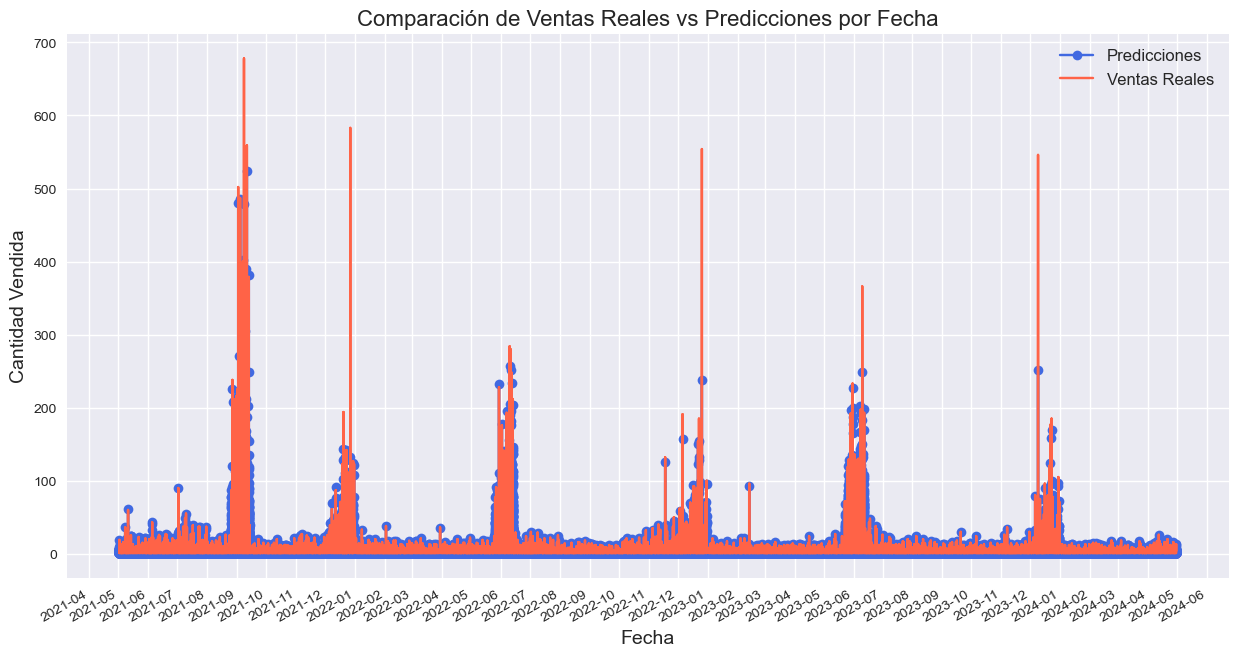

In [34]:


plt.figure(figsize=(15, 8))  # Tamaño del gráfico
plt.style.use('seaborn-darkgrid')  # Estilo de fondo de cuadrícula con tema oscuro

# Gráfico de predicciones
plt.plot(predictions['Fecha_venta'], predictions['prediction_label'], label='Predicciones', marker='o', linestyle='-', color='royalblue')

# Gráfico de ventas reales
plt.plot(df_completo['Fecha_venta'], df_completo['Cant_vendidas'], label='Ventas Reales', marker='x', linestyle='-', color='tomato')

# Configuración de los formatos de fecha en el eje X
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Intervalo mensual
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato año-mes

plt.title('Comparación de Ventas Reales vs Predicciones por Fecha', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Mejorar la rotación y alineación de las etiquetas de fecha
plt.gcf().autofmt_xdate()

plt.savefig('high_quality_chart.png', dpi=300)  # Guardar como imagen de alta calidad
plt.show()


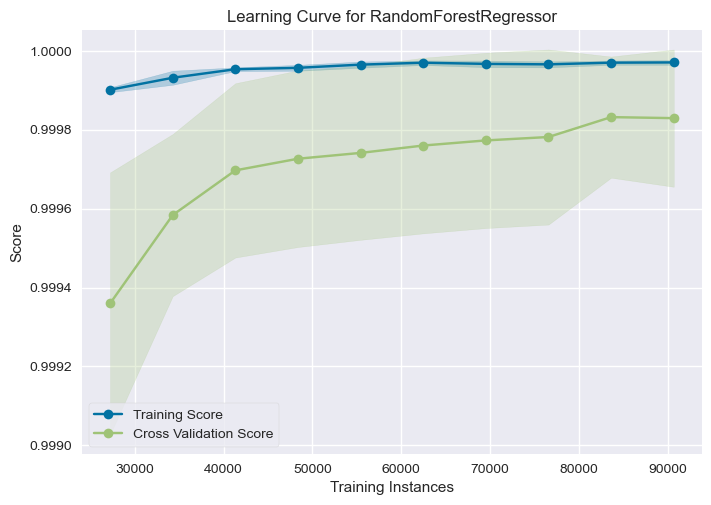

In [39]:
# Gráfico de aprendizaje para evaluar el overfitting
plot_model(tuned_model, plot='learning')


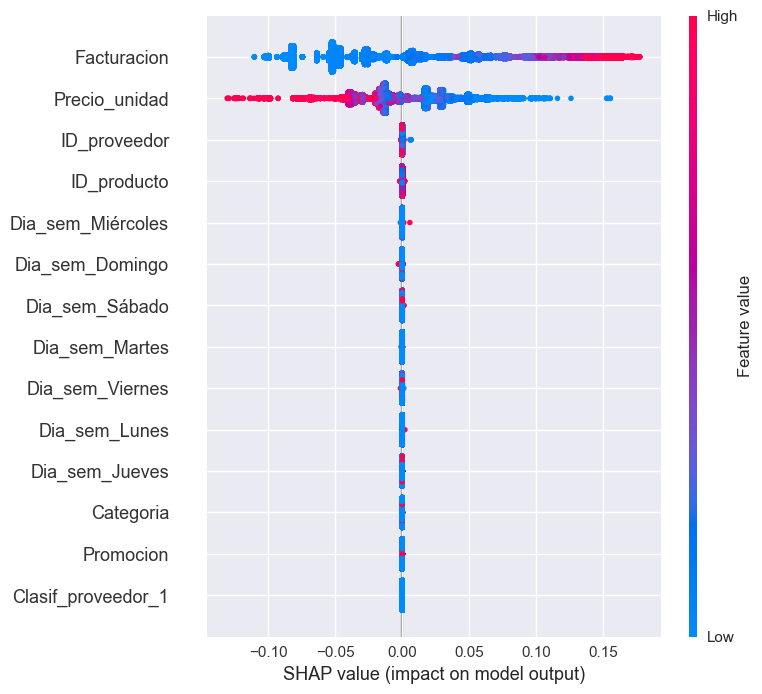

In [38]:
# Interpretación del modelo para Random Forest
interpret_model(tuned_model)
